# Data Viz and Analysis on the LeaderBoard
 
I'm Parker Burchett (MrQuantsALot) and created this notebook to do some 
 
The beautiful thing about blockchain is that since everything is public and anonymous you can just look at the data.  After spending a few days writing this, I am pretty sure that I have a reasonable chance and creating a profitable model.
 
I looked at the characteristics and distribution of successful users. 
 
If you have any feedback or suggestions please let me know on the forum. I am still a novice at this kind of analysis and I am sure there are things that I missed or misinterpreted. In particular, I don't know why there is a negative coefficient on the FNC -> 3M_returns OLS regression. 
 
This notebook does the following when you run it:
 
1. Query the [Numerai Leaderboard](https://numer.ai/tournament) and cast it as a Pandas Dataframe.
2. Visualize the relationship between the stake size, performance metrics and returns. 
3. OLS Regression on returns.  
 
All of the methods are written such that you can change the dependent and independent variables. I included the visualizations I thought were interesting but you can check out the other variables yourself. The numbers will change as the leaderboard updates. 
 

In [16]:
!pip install numpy
!pip install pandas 
!pip install json 
!pip install requests 
!pip install matplotlib
!pip install statsmodels 
%matplotlib inline

ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


# Import packages

In [17]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime

# Ping the Leaderboard

In [18]:
def get_leaderboard() -> pd.DataFrame:
    """
        Ping the Numerai leaderboard and return a Pandas DataFrame of the contents.
    """
    url = 'https://api-tournament.numer.ai/'
    # this is a Graphql query, that lets me get exactly and only the data I want. 
    query = """{ 
    v2Leaderboard {
        returns
        corrRep
        fncRep
        mmcRep
        username
        nmrStaked
        returns 
        return_52Weeks
        return_13Weeks
        rank
        }  
    }"""
    r = requests.post(url=url, json={'query': query})
    json_data = json.loads(r.text)
    df_data = json_data['data']['v2Leaderboard']
    df = pd.DataFrame(df_data)
    df.convert_dtypes() # the auto casts the columns into what it thinks is the most appropriate 
    df['nmrStaked'] = pd.to_numeric(df['nmrStaked']) # for some reason nmrStaked does not get auto cast as a numaric
 
    #Renaming the columns
    df = df.rename(columns={'returns': '1D_returns', 'return_13Weeks': '3M_returns', 'return_52Weeks': '1Y_returns'})
    return df
 
df = get_leaderboard()
print(df.count())
df.head(10)

corrRep       7707
fncRep        7707
mmcRep        7707
nmrStaked     7707
rank          7707
3M_returns    2621
1Y_returns     569
1D_returns    3312
username      7707
dtype: int64


,corrRep,fncRep,mmcRep,nmrStaked,rank,3M_returns,1Y_returns,1D_returns,username
0,0.060670,0.015924,0.023843,136.881940,1,89.060053,NaN,2.120720,mdl3
1,0.059164,0.008850,0.028037,44.304471,2,136.715146,NaN,-2.260499,nescience
2,0.057394,0.015660,0.018075,0.000000,3,NaN,NaN,NaN,sapphirescipionyx
3,0.057326,0.017466,0.018394,0.000000,4,NaN,NaN,NaN,quantaquetzalcoatlus
4,0.056010,0.011212,0.015671,0.000000,5,NaN,NaN,NaN,anna13
5,0.055391,0.007498,0.020652,18.070287,6,95.060294,NaN,1.913908,uuazed6
6,0.054912,0.004802,0.018949,50.719912,7,NaN,NaN,4.301766,uuazed4
7,0.054440,0.019915,0.012765,0.621972,8,116.543521,609.696609,2.955487,victoria
8,0.054286,0.003859,0.020236,2147.418467,9,99.089504,501.194563,6.399607,benben11
9,0.054031,0.011813,0.013653,0.000000,10,NaN,NaN,NaN,sinookas


# Methods to create plots

### Each method has the optional param min_stake. Use it to exclude low stake  users. 


In [19]:
def create_histogram(df, col='corrRep', bins=50, min_stake=0, max_stake=1000000):
    x = df[((df[col].notnull()) & (df['nmrStaked'] > min_stake)) & (df['nmrStaked'] < max_stake)][col]
    plt.hist(x, bins, label=f'{col} when nmrStaked>{min_stake}', alpha=.5)
    plt.xlabel(col)
    plt.ylabel('Count')
    num_elements = x.count()    
    return plt
 
def create_scatter_plot(df, x_name='corrRep', y_name='fncRep', min_stake=0, max_stake=1000000):
 
    # these are ugly one liners if you are unfamiliar with pandas.
    # They select a subset of the Dataframe df based on compound booleans. Think of them as SELECT x_name WHERE bool1, bool2... if you were writing SQL
    # (df[x_name].notnull()) get rows when x_name is not null
    # df['nmrStaked'] > min_stake) get rows where the stake is greater than the min_stake
    # df['nmrStaked'] < max_stake) get rows where the stake is less than the max stake
    # [x_name] says only give me the column with name x_name
    x = df[((df[x_name].notnull()) & (df['nmrStaked'] > min_stake)) & (df['nmrStaked'] < max_stake)][x_name]
    y = df[((df[y_name].notnull()) & (df['nmrStaked'] > min_stake)) & (df['nmrStaked'] < max_stake)][y_name]
    plt.scatter(x, y, s=.5)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    num_elements = x.count()
    plt.title(
        f'{y_name} v {x_name} when nmrStaked>{min_stake}\n Number of Elements:{num_elements}'
    )
    return plt
 
plt.rcParams["figure.figsize"] = (6,6) # changes the default size of the graphs

## Histogram of 3 Month Returns by Stake Size

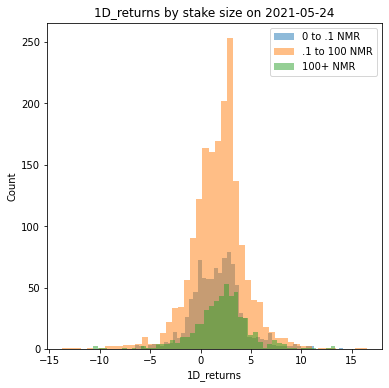

In [20]:
col = '1D_returns' # change this to be '1D_returns' or '1Y_returns' or 'corrRep', 'fncRep' to see other distributions

create_histogram(df,col=col, min_stake=0, max_stake=.1)
create_histogram(df,col=col, min_stake=.1, max_stake=100)
create_histogram(df, col=col,min_stake=100, max_stake=1000000)

today = datetime.datetime.now().date()
labels = ['0 to .1 NMR','.1 to 100 NMR','100+ NMR']
plt.legend(labels)
plt.title(f'{col} by stake size on {today}')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, '1D_returns')

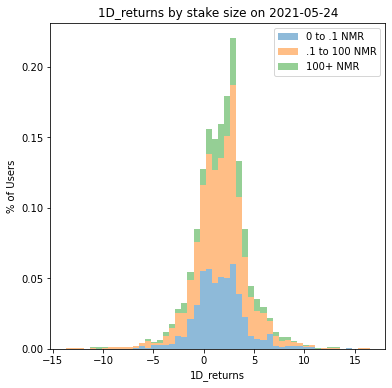

In [21]:
col = '1D_returns'

# hist with percentages
df['size_category'] = '0 to .1 NMR'
df.loc[(df['nmrStaked'] > .1) & (df['nmrStaked'] < 100), 'size_category'] = '.1 to 100 NMR'
df.loc[(df['nmrStaked'] > 100), 'size_category']  = '100+ NMR'

data_for_daily_hist = df[[col,'nmrStaked','size_category']]
user_cat_list =[]
for label in labels:
  user_cat_list.append(np.array(data_for_daily_hist.loc[data_for_daily_hist['size_category'] == label][col]))

plt.hist(user_cat_list,bins=50, alpha =.5,stacked=True, density=True)

labels = ['0 to .1 NMR','.1 to 100 NMR','100+ NMR']
plt.legend(labels)
plt.title(f'{col} by stake size on {today}')
plt.ylabel('% of Users')
plt.xlabel(f'{col}')

Text(0.5, 0, '1D_returns')

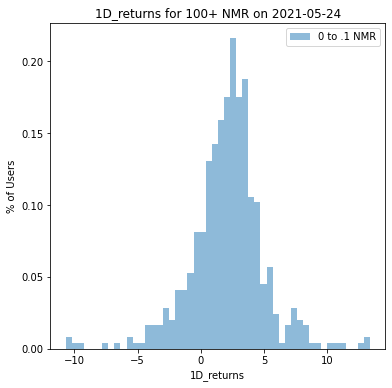

In [22]:
col = '1D_returns'

# hist with percentages
df['size_category'] = '0 to .1 NMR'
df.loc[(df['nmrStaked'] > .1) & (df['nmrStaked'] < 100), 'size_category'] = '.1 to 100 NMR'
df.loc[(df['nmrStaked'] > 100), 'size_category']  = '100+ NMR'

data_for_daily_hist = df[[col,'nmrStaked','size_category']]
user_cat_list =[]
for label in labels:
  user_cat_list.append(np.array(data_for_daily_hist.loc[data_for_daily_hist['size_category'] == label][col]))

large_staker_np = user_cat_list[2]

plt.hist(large_staker_np,bins=50, alpha =.5,stacked=True, density=True)

labels = ['0 to .1 NMR','.1 to 100 NMR','100+ NMR']
plt.legend(labels)
plt.title(f'{col} for {labels[2]} on {today}')
plt.ylabel('% of Users')
plt.xlabel(f'{col}')

## Histogram of 3 Month returns excluding where stake is < .1

### This excludes everyone that is only betting the free .01 NMR given out. Staking .1 NMR is only about $4 right now so it is not much of a cut off. 



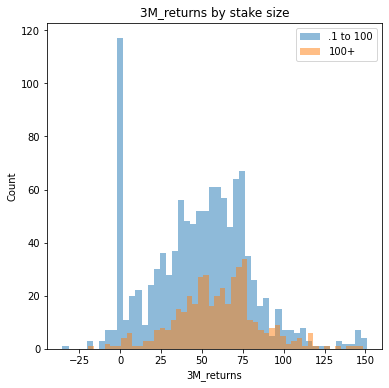

In [23]:
col = '3M_returns'

create_histogram(df,col=col, min_stake=.1, max_stake=100)
create_histogram(df, col=col,min_stake=100, max_stake=1000000)

plt.legend(['.1 to 100','100+'])
plt.title(f'{col} by stake size')
plt.show()

## Histogram of Corr by Stake Size
 
- This forms a bimodal distribution at corrRep = -.1 and corrRep = ~+.025
- I suspect the cluster at exactly corrRep =-.1 is because every score worse than that is recorded as -.1. This would prevent a savvy person from figuring the actual true predictions by submitting a whole bunch of different submissions and then comparing the Corr scores. I don’t know that for certain but it's the best explanation I can think of.


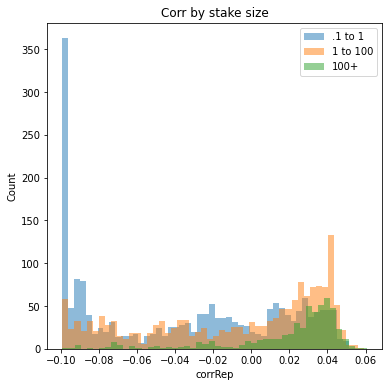

In [24]:
col = 'corrRep'

create_histogram(df,col=col, min_stake=0, max_stake=1)
create_histogram(df,col=col, min_stake=1, max_stake=100)
create_histogram(df,col=col,min_stake=100, max_stake=1000000)

plt.legend(['.1 to 1','1 to 100','100+'])
plt.title("Corr by stake size")
plt.show()

# Scatter Plots


Index(['corrRep', 'fncRep', 'mmcRep', 'nmrStaked', 'rank', '3M_returns',
       '1Y_returns', '1D_returns', 'username', 'size_category'],
      dtype='object')


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

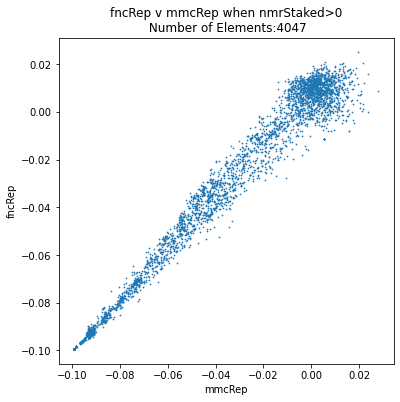

In [25]:
print(df.columns)
create_scatter_plot(df, x_name='mmcRep', y_name='fncRep')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

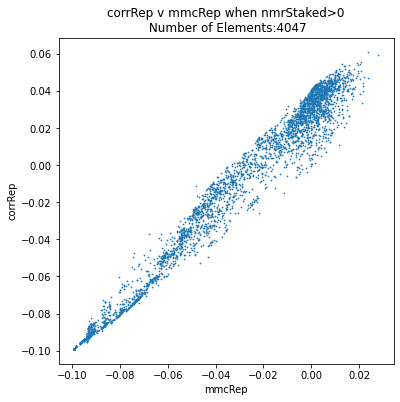

In [26]:
create_scatter_plot(df, x_name='mmcRep', y_name='corrRep')

# Methods to for Ordinary Least Squares Regression
 
## [Read about OLS on Wikipedia](https://en.wikipedia.org/wiki/Ordinary_least_squares)
### I am primarily interested in the relationship between stake size and returns. From an economics perspective one would expect people to bet more money on models that have a higher correlation score. This would mean a positive correlation between stake size and returns. 
 



In [27]:
def compute_single_regression(df,
                              independent_variable='corrRep',
                              dependent_variable='3M_returns',
                              min_stake=0):

    x = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][independent_variable]
    y = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][dependent_variable]
    model = sm.OLS(y, x)
    results = model.fit()
    return results


def compute_multiple_regression(
        df,
        indepenent_variables=['corrRep', 'fncRep', 'mmcRep', 'nmrStaked'],
        dependent_variable='3M_returns',
        min_stake=0):
    x = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][indepenent_variables]
    y = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][dependent_variable]
    model = sm.OLS(y, x)
    results = model.fit()
    return results


## Single Regression Stake Size and 3 Month Returns

In [28]:
results = compute_single_regression(df,independent_variable='nmrStaked',dependent_variable='3M_returns', min_stake=1)
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             3M_returns   R-squared (uncentered):                   0.090
Model:                            OLS   Adj. R-squared (uncentered):              0.089
Method:                 Least Squares   F-statistic:                              136.3
Date:                Mon, 24 May 2021   Prob (F-statistic):                    4.22e-30
Time:                        20:01:57   Log-Likelihood:                         -7590.3
No. Observations:                1382   AIC:                                  1.518e+04
Df Residuals:                    1381   BIC:                                  1.519e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
nmrStaked      0.0233      0.002     11.675      0.000       0.019       0.027
==============================================================================
Omnibus:                      282.139   Durbin-Watson:                   0.391
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1583.011
Skew:                          -0.827   Prob(JB):                         0.00
Kurtosis:                       7.975   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Findings
 
## There is a small significant positive relationship between amount staked and 3-month returns (coef= 0.0086, p<.000). However, only looking at stake size does not explain much of the variance in the 3-month returns. 
 
- The R^2 value is .027, I thought this would be much larger.
- One explanation is that having access to a lot of capital is not indicative of being good at model building. 
- There are a lot of low capital high skill data scientists out there
- These numbers change day to day since this notebook pings the leaderboard each time it is run
 

## Multiple Regression on 1D returns. 
 
### This is looking at the relative impact of CORR, MMC, FNC, and Stake on returns. Because this is only 1D returns one would expect these features to poorly predict returns because there is so much variance in 1D returns. 
 

In [29]:
# multiple regression looks at the impact of several independent variables on the dependent variable.
# I set the default independent variables to ['corrRep', 'fncRep', 'mmcRep', 'nmrStaked']
results = compute_multiple_regression(df,dependent_variable='1D_returns')
results.summary()
 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             1D_returns   R-squared (uncentered):                   0.367
Model:                            OLS   Adj. R-squared (uncentered):              0.366
Method:                 Least Squares   F-statistic:                              470.2
Date:                Mon, 24 May 2021   Prob (F-statistic):                   4.57e-320
Time:                        20:01:57   Log-Likelihood:                         -7685.7
No. Observations:                3249   AIC:                                  1.538e+04
Df Residuals:                    3245   BIC:                                  1.540e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
corrRep       89.2369      2.480     35.976      0.000      84.374      94.100
fncRep      -100.6361      7.342    -13.707      0.000    -115.031     -86.241
mmcRep        -4.2881      5.837     -0.735      0.463     -15.732       7.156
nmrStaked  -7.386e-05   8.61e-05     -0.858      0.391      -0.000    9.49e-05
==============================================================================
Omnibus:                      301.036   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1877.545
Skew:                          -0.178   Prob(JB):                         0.00
Kurtosis:                       6.707   Cond. No.                     1.12e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


## Multiple Regression on 3 Month Returns

In [30]:
results = compute_multiple_regression(df,dependent_variable='3M_returns', min_stake=.1)
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             3M_returns   R-squared (uncentered):                   0.908
Model:                            OLS   Adj. R-squared (uncentered):              0.908
Method:                 Least Squares   F-statistic:                              3833.
Date:                Mon, 24 May 2021   Prob (F-statistic):                        0.00
Time:                        20:01:57   Log-Likelihood:                         -6726.4
No. Observations:                1557   AIC:                                  1.346e+04
Df Residuals:                    1553   BIC:                                  1.348e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
corrRep     2309.9244     22.207    104.019      0.000    2266.366    2353.483
fncRep     -1710.5247     69.345    -24.667      0.000   -1846.543   -1574.506
mmcRep      -564.4177     57.453     -9.824      0.000    -677.112    -451.724
nmrStaked     -0.0005      0.001     -0.721      0.471      -0.002       0.001
==============================================================================
Omnibus:                      297.213   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1046.550
Skew:                           0.912   Prob(JB):                    5.55e-228
Kurtosis:                       6.578   Cond. No.                     1.44e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Multiple Regression on 1 Year Returns

In [31]:
results = compute_multiple_regression(df, dependent_variable='1Y_returns')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             1Y_returns   R-squared (uncentered):                   0.863
Model:                            OLS   Adj. R-squared (uncentered):              0.862
Method:                 Least Squares   F-statistic:                              890.1
Date:                Mon, 24 May 2021   Prob (F-statistic):                   2.97e-242
Time:                        20:01:57   Log-Likelihood:                         -3225.6
No. Observations:                 569   AIC:                                      6459.
Df Residuals:                     565   BIC:                                      6477.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
corrRep     6787.5909    155.334     43.697      0.000    6482.488    7092.694
fncRep     -3256.3718    500.513     -6.506      0.000   -4239.465   -2273.278
mmcRep     -3506.9392    409.192     -8.570      0.000   -4310.663   -2703.215
nmrStaked      0.0088      0.003      2.890      0.004       0.003       0.015
==============================================================================
Omnibus:                      108.581   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              277.889
Skew:                           0.963   Prob(JB):                     4.54e-61
Kurtosis:                       5.831   Cond. No.                     2.30e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# What do the long-term profits look like?

In [32]:
users_with_3_month_returns = df[df['3M_returns'].notnull()]['3M_returns']
num_3M_returns = users_with_3_month_returns.count()
 
print('Description users with 3 months of returns\n', users_with_3_month_returns.describe())
 
users_net_postive_3_month_returns = df[(df['3M_returns'].notnull()) & (df['3M_returns'] > 0)]['3M_returns']
num_net_postitive = users_net_postive_3_month_returns.count()
 
percent_net_positive = "{:.1%}".format(num_net_postitive/num_3M_returns)
 
print(f'Users who were net positive over 3 months: {percent_net_positive}')
 
users_net_up_10_percent = df[(df['3M_returns'].notnull()) & (df['3M_returns'] > 10)]['3M_returns']
num_net_up_10_percent = users_net_up_10_percent.count()
 
percent_net_up_10 = "{:.1%}".format(num_net_up_10_percent/num_3M_returns)
print(f'Users who were net up 10% over 3 months: {percent_net_up_10}')
 
users_net_up_50_percent = df[(df['3M_returns'].notnull()) & (df['3M_returns'] > 50)]['3M_returns']
num_net_up_50_percent = users_net_up_50_percent.count()
 
percent_net_up_50 = "{:.1%}".format(num_net_up_50_percent/num_3M_returns)
print(f'Users who were net up 50% over 3 months: {percent_net_up_50}')

# you might want to include a bit about the t-test of the groups by stake size here.

Description users with 3 months of returns
 count    2621.000000
mean       41.060515
std        34.573713
min       -85.770690
25%         3.042035
50%        43.523964
75%        66.265233
max       150.841867
Name: 3M_returns, dtype: float64
Users who were net positive over 3 months: 76.9%
Users who were net up 10% over 3 months: 72.0%
Users who were net up 50% over 3 months: 43.2%


# Conclusions
1. I was surprised that there is a negative relationship between FNC and 3M and 1Y returns. I would have expected each of those parameters to have positive coefficients. 
2. The R^2 increases when you look at larger time frames. This matches intuition and the law of large numbers. As you increase the time period you consider, the randomness in the 1D and 3M returns evens out. 
3. Because there is such a small relationship between stake size and returns, I can conclude that you don't need access to large amounts of capital to build a good model. If you look at the leaderboard right now, there are people who have staked anywhere from 0 to ~1,000 NMR that have similar CORR scores.
4. It seems like betting any amount of money on your model is enough of a signal of confidence in it. There is not that much of a difference between beting 1 and 1000 NMR. This surprised me a lot.
5. Because some people might have multiple accounts, there is an upper bound of ~900 people who have successfully built models to forecast the stock market well enough to get net +10% over three months. What a time to be alive. 
 

# Next Steps
 
- Figure out the life cycle of a typical user. How long does it take for them to be profitable, how much turnover is there? How many people just submit the intro model and give up? I am pretty sure I can get this data from the API.
 
- Track these variables over time. I could store the results from the leaderboard every day and then come back in a month and see if it has changed at all.

- I could calcuate the 1_day returns each day and turn them into a gif that shows how the leaderboard moved around each day.